# 🕯️ Анализ японских свечей

![](https://www.tradingwithrayner.com/wp-content/uploads/2019/03/1-OHLC-COMBINE-1024x732.png)

Выгружаем данные с Мосбиржи, используя парсер с гитхаба (https://github.com/nerevar/stock_prices).
Имеем таблицы с информацией по акциям, облигациям и курсу валют за указанный период.

In [ ]:
# рынок облигаций, Мосбиржа
!python main.py download --engine stock --market bonds --date 2022-06-01 --dateend 2022-11-01

# рынок акций/ETF, Мосбиржа
!python main.py download --engine stock --market shares --date 2022-06-01 --dateend 2022-11-01

# индексы, Мосбиржа
!python main.py download --engine stock --market index ---date 2022-06-01 --dateend 2022-11-01

# валюта, Мосбиржа
!python main.py download --engine currency --market selt --date 2022-06-01 --dateend 2022-11-01

In [ ]:
# Jupyter notebook setup

import re
import math
import json
import pytz
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# === jupyter notebook config === 
# Show all output values in cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# === numpy & pandas config ===
np.set_printoptions(linewidth=240)
np.set_printoptions(threshold=np.inf)

pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', '{: .2f}'.format)

# === graphs config ===
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams['savefig.dpi'] = 200

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 17, 8
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20

plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.weight'] = 'normal'

plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.style.use('bmh')
plt.style.use('fivethirtyeight')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
import pip
pip.main(["install", "mpl_finance"])
from mpl_finance import candlestick_ohlc
import pandas as pd
import matplotlib.dates as mpl_dates

plt.style.use('ggplot')

In [ ]:
import os

li = []

for root, directories, filenames in os.walk('./quotes'):
    for filename in filenames:
        df = pd.read_csv(os.path.join(root,filename), index_col=None, header=0)
        li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
df.shape
df.head(10)

(199189, 58)

,BOARDID,TRADEDATE,SHORTNAME,SECID,NUMTRADES,VALUE,LOW,HIGH,CLOSE,LEGALCLOSEPRICE,ACCINT,WAPRICE,YIELDCLOSE,OPEN,VOLUME,MARKETPRICE2,MARKETPRICE3,ADMITTEDQUOTE,MP2VALTRD,MARKETPRICE3TRADESVALUE,ADMITTEDVALUE,MATDATE,DURATION,YIELDATWAP,IRICPICLOSE,BEICLOSE,COUPONPERCENT,COUPONVALUE,BUYBACKDATE,LASTTRADEDATE,FACEVALUE,CURRENCYID,CBRCLOSE,YIELDTOOFFER,YIELDLASTCOUPON,OFFERDATE,FACEUNIT,TRADINGSESSION,WAVAL,VOLRUR,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,open (RUB),high (RUB),low (RUB),close (RUB),open (USD),high (USD),low (USD),close (USD),market cap (USD)
0,TQCB,2022-11-01,РЖД-19 обл,RU000A0JQ7Z2,27.00,161825.50,99.12,99.61,99.53,99.53,24.30,99.28,8.31,99.34,163.00,NaN,99.30,99.53,0.00,5277672.20,0.00,2024-07-08,575.00,8.48,NaN,NaN,7.85,39.14,NaN,2022-11-01,1000.00,SUR,NaN,NaN,NaN,NaN,RUB,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TQCB,2022-11-01,РЖД-23 обл,RU000A0JQRD9,49.00,320845.00,97.34,101.14,98.70,98.70,22.15,98.72,8.68,101.14,325.00,NaN,98.64,98.70,0.00,510967.40,0.00,2025-01-16,740.00,8.67,NaN,NaN,7.85,39.14,NaN,2022-11-01,1000.00,SUR,NaN,NaN,NaN,NaN,RUB,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TQCB,2022-11-01,СЗКК 03,RU000A0JRU20,2.00,10374.00,100.00,100.00,100.00,100.00,9.46,100.00,17.93,100.00,13.00,99.67,99.69,100.00,550416.43,501981.90,550416.43,2031-09-26,157.00,17.93,NaN,NaN,17.30,68.84,2023-04-07,2022-11-01,798.00,SUR,NaN,NaN,NaN,NaN,RUB,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TQCB,2022-11-01,СЗКК 04,RU000A0JRU46,4.00,41496.00,100.00,100.00,100.00,100.00,9.46,100.00,17.93,100.00,52.00,100.00,100.00,100.00,899326.05,895356.00,899326.05,2031-09-26,157.00,17.93,NaN,NaN,17.30,68.84,2023-04-07,2022-11-01,798.00,SUR,NaN,NaN,NaN,NaN,RUB,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TQCB,2022-11-01,ВЭБ.РФ 21,RU000A0JS4Z7,2.00,21210.00,101.00,101.00,101.00,101.00,18.97,101.00,7.87,101.00,21.00,NaN,102.82,101.00,0.00,507941.10,0.00,2032-02-17,119.00,7.87,NaN,NaN,10.99,54.80,2023-02-28,2022-11-01,1000.00,SUR,NaN,NaN,NaN,NaN,RUB,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,TQCB,2022-11-01,РЖД-32 обл,RU000A0JSGV0,15.00,78911.30,100.16,101.31,101.25,101.28,31.46,101.17,8.09,100.16,78.00,NaN,101.09,101.28,0.00,545866.70,0.00,2032-06-25,240.00,8.22,NaN,NaN,9.90,49.36,2023-07-07,2022-11-01,1000.00,SUR,NaN,NaN,NaN,NaN,RUB,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,TQCB,2022-11-01,ВЭБ.РФ 18,RU000A0JT403,1.00,960.00,96.00,96.00,96.00,96.00,6.72,96.00,10.27,96.00,1.00,NaN,NaN,96.00,0.00,0.00,0.00,2032-09-17,656.00,10.27,NaN,NaN,7.67,38.24,2024-09-27,2022-11-01,1000.00,SUR,NaN,10.20,NaN,2024-10-01,RUB,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,TQCB,2022-11-01,Башнефть06,RU000A0JTM28,4.00,6004.80,100.08,100.08,100.08,100.08,19.20,100.08,7.43,100.08,6.00,NaN,99.97,100.08,0.00,565819.90,0.00,2023-01-31,91.00,7.43,NaN,NaN,7.70,38.39,NaN,2022-11-01,1000.00,SUR,NaN,NaN,7.15,NaN,RUB,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,TQCB,2022-11-01,Башнефть07,RU000A0JTM36,1.00,1004.70,100.47,100.47,100.47,100.47,20.69,100.47,6.38,100.47,1.00,100.05,100.05,100.47,10613238.70,10260111.70,10613238.70,2023-01-31,91.00,6.38,NaN,NaN,8.30,41.39,NaN,2022-11-01,1000.00,SUR,NaN,NaN,6.17,NaN,RUB,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,TQCB,2022-11-01,Башнефть08,RU000A0JTM44,20.00,224906.00,99.60,100.01,99.90,99.90,19.20,99.96,8.20,100.01,225.00,NaN,99.99,99.90,0.00,792906.00,0.00,2023-01-31,91.00,7.94,NaN,NaN,7.70,38.39,NaN,2022-11-01,1000.00,SUR,NaN,NaN,7.87,NaN,RUB,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
sber = df[(df.BOARDID == 'TQBR') & (df.SECID == 'SBER')].sort_values(by='TRADEDATE')
# sber.dropna(axis=1, how='all')[['OPEN', 'CLOSE', 'VOLUME', 'TRADEDATE']]
sber.head(10)

,BOARDID,TRADEDATE,SHORTNAME,SECID,NUMTRADES,VALUE,LOW,HIGH,CLOSE,LEGALCLOSEPRICE,ACCINT,WAPRICE,YIELDCLOSE,OPEN,VOLUME,MARKETPRICE2,MARKETPRICE3,ADMITTEDQUOTE,MP2VALTRD,MARKETPRICE3TRADESVALUE,ADMITTEDVALUE,MATDATE,DURATION,YIELDATWAP,IRICPICLOSE,BEICLOSE,COUPONPERCENT,COUPONVALUE,BUYBACKDATE,LASTTRADEDATE,FACEVALUE,CURRENCYID,CBRCLOSE,YIELDTOOFFER,YIELDLASTCOUPON,OFFERDATE,FACEUNIT,TRADINGSESSION,WAVAL,VOLRUR,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,open (RUB),high (RUB),low (RUB),close (RUB),open (USD),high (USD),low (USD),close (USD),market cap (USD)
161527,TQBR,2022-06-01,Сбербанк,SBER,104059.00,5296798375.30,117.00,122.69,121.97,121.97,NaN,120.97,NaN,117.50,43785040.00,120.97,120.97,121.97,5296798375.30,5296798375.30,5296798375.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142394,TQBR,2022-06-02,Сбербанк,SBER,101114.00,5125256938.40,118.50,122.39,119.00,119.00,NaN,119.87,NaN,121.90,42769900.00,119.83,119.83,119.00,5125256938.40,5125256938.40,5125256938.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140874,TQBR,2022-06-03,Сбербанк,SBER,80343.00,4067212982.50,117.18,120.16,119.21,119.21,NaN,118.43,NaN,119.29,34341530.00,118.43,118.43,119.21,4067212982.50,4067212982.50,4067212982.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163334,TQBR,2022-06-06,Сбербанк,SBER,61834.00,2652231034.20,118.29,120.35,118.78,118.78,NaN,119.03,NaN,119.26,22281970.00,119.03,119.03,118.78,2652231034.20,2652231034.20,2652231034.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156434,TQBR,2022-06-07,Сбербанк,SBER,59242.00,2629117760.20,117.32,118.90,118.32,118.32,NaN,118.04,NaN,118.68,22274020.00,118.04,118.04,118.32,2629117760.20,2629117760.20,2629117760.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159960,TQBR,2022-06-08,Сбербанк,SBER,91893.00,5003858591.90,118.40,122.19,119.90,119.90,NaN,120.53,NaN,118.51,41514970.00,120.53,120.53,119.90,5003858591.90,5003858591.90,5003858591.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156837,TQBR,2022-06-09,Сбербанк,SBER,80871.00,3477327986.10,117.70,120.20,118.20,118.20,NaN,118.39,NaN,120.00,29371970.00,118.39,118.39,118.20,3477327986.10,3477327986.10,3477327986.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152211,TQBR,2022-06-10,Сбербанк,SBER,66107.00,3006397517.20,117.73,119.55,118.07,118.07,NaN,118.49,NaN,118.03,25373000.00,118.49,118.49,118.07,3006397517.20,3006397517.20,3006397517.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168091,TQBR,2022-06-14,Сбербанк,SBER,92504.00,4454820677.70,115.80,119.88,118.98,118.98,NaN,118.19,NaN,118.03,37690460.00,118.19,118.19,118.98,4454820677.70,4454820677.70,4454820677.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167613,TQBR,2022-06-15,Сбербанк,SBER,109377.00,6293254524.80,118.71,121.71,121.14,121.14,NaN,120.46,NaN,119.40,52262500.00,120.42,120.42,121.14,6293254524.80,6293254524.80,6293254524.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
red = "#FF4500"
green = "#00B060"

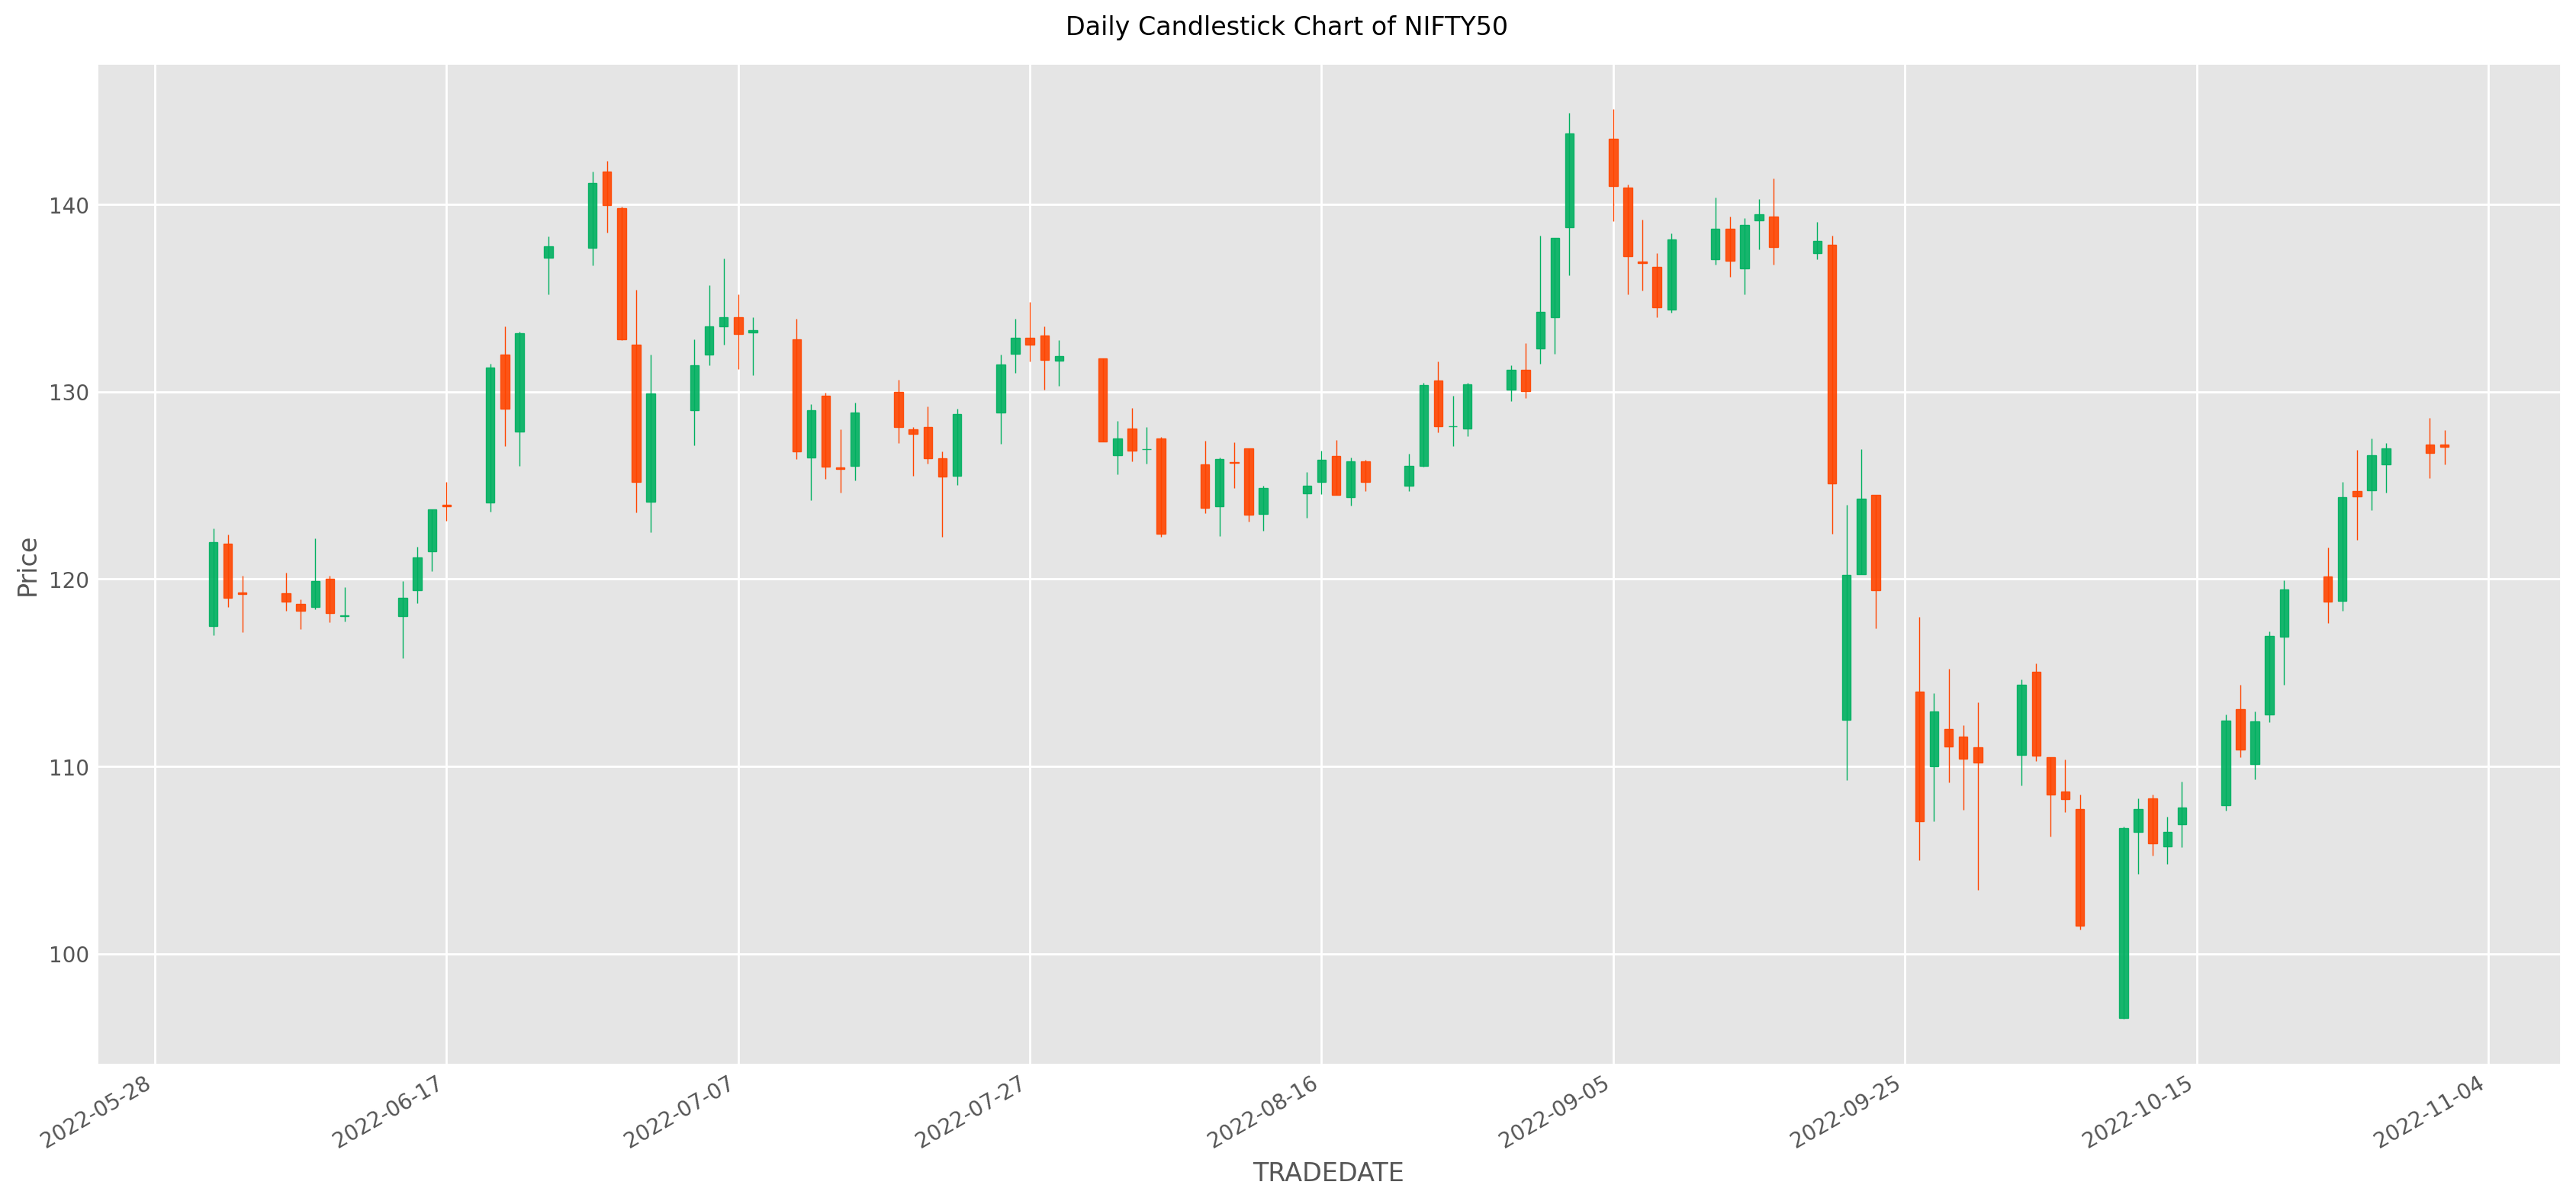

In [ ]:
import datetime
  
# Extracting Data for plotting
ohlc = sber.loc[:, ['TRADEDATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE']]
  
# Converting date into datetime format
ohlc['TRADEDATE'] = pd.to_datetime(ohlc['TRADEDATE'])
ohlc['TRADEDATE'] = ohlc['TRADEDATE'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)
  
# Creating Subplots
fig, ax = plt.subplots()
  
candlestick_ohlc(ax, ohlc.values, width=0.6,
                 colorup= green, colordown= red, alpha=0.9)
  
# Setting labels & titles
ax.set_xlabel('TRADEDATE')
ax.set_ylabel('Price')
fig.suptitle('Daily Candlestick Chart of NIFTY50')
  
# Formatting Date
date_format = mpl_dates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
  
fig.tight_layout()
plt.show();
  


In [ ]:
ohlc['TRADEDATE'] = pd.to_datetime(sber['TRADEDATE'])
ohlc["LEN"] = ohlc["CLOSE"] - ohlc["OPEN"]
ohlc.head(10)

,TRADEDATE,OPEN,HIGH,LOW,CLOSE,LEN
161527,2022-06-01,117.50,122.69,117.00,121.97,4.47
142394,2022-06-02,121.90,122.39,118.50,119.00,-2.90
140874,2022-06-03,119.29,120.16,117.18,119.21,-0.08
163334,2022-06-06,119.26,120.35,118.29,118.78,-0.48
156434,2022-06-07,118.68,118.90,117.32,118.32,-0.36
159960,2022-06-08,118.51,122.19,118.40,119.90,1.39
156837,2022-06-09,120.00,120.20,117.70,118.20,-1.80
152211,2022-06-10,118.03,119.55,117.73,118.07,0.04
168091,2022-06-14,118.03,119.88,115.80,118.98,0.95
167613,2022-06-15,119.40,121.71,118.71,121.14,1.74


In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [ ]:
my_palette = [red if (i < 0) else green for i in ohlc["SIGN"] ]

In [ ]:
ohlc["SIGN"] = ohlc["LEN"] / abs(ohlc["LEN"])

In [ ]:
%time

df2 = pd.DataFrame(columns=["LEN", "Count"])
i = 0
while i < len(ohlc):
    cur_sum = ohlc["LEN"].iloc[i]
    date = ohlc.index[i]
    cur_num = 1
    while (i + 1 < len(ohlc) ) and (ohlc["SIGN"].iloc[i] == ohlc["SIGN"].iloc[i + 1]):
        cur_num += 1
        cur_sum += ohlc["LEN"].iloc[i + 1]
        i += 1
    else:
        df2 = pd.concat([df2, pd.DataFrame({"LEN" : [cur_sum], "Count" : [cur_num]}, index=[date])])
    i += 1

CPU times: user 1e+03 ns, sys: 4 µs, total: 5 µs
Wall time: 7.15 µs


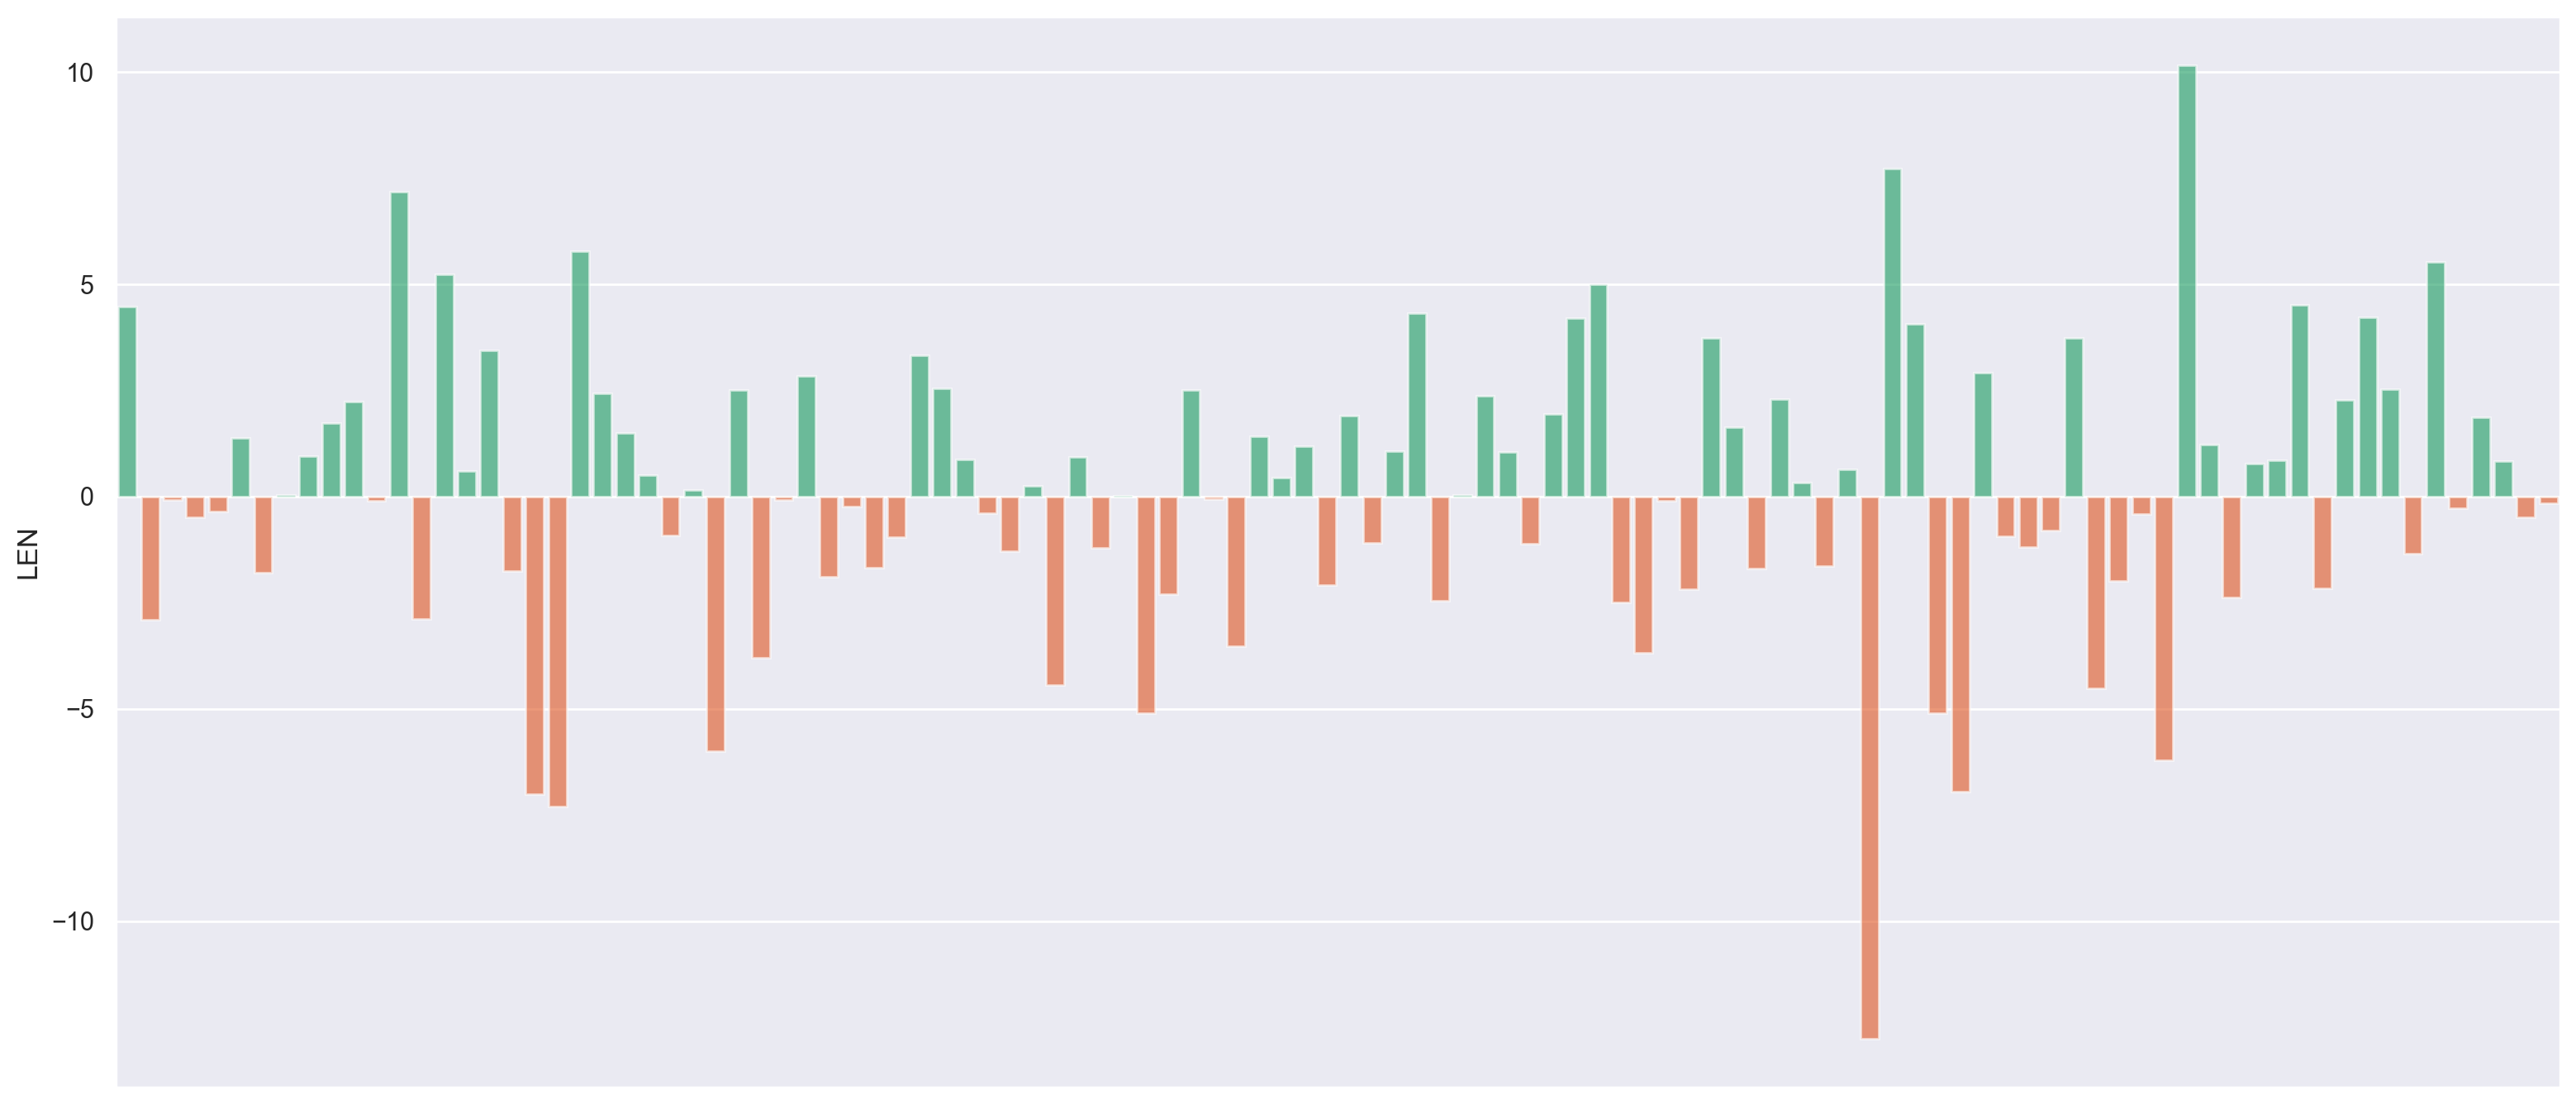

In [ ]:
fig = sns.barplot(data = ohlc, x = "TRADEDATE", y = "LEN", palette = my_palette, alpha = 0.6);
fig.axes.get_xaxis().set_visible(False)

In [ ]:
count = 0
for i in (ohlc["LEN"]):
    if i < 0:
        count += 1
print(count)

52


/var/folders/pb/g1nm2p2s2_v8x88dfjw78sf80000gn/T/ipykernel_27997/3372633404.py:3: UserWarning: The palette list has more values (108) than needed (2), which may not be intended.
  sns.histplot(data = ohlc, x = "LEN", kde = True, bins = 80, hue='SIGN', palette = my_palette1);


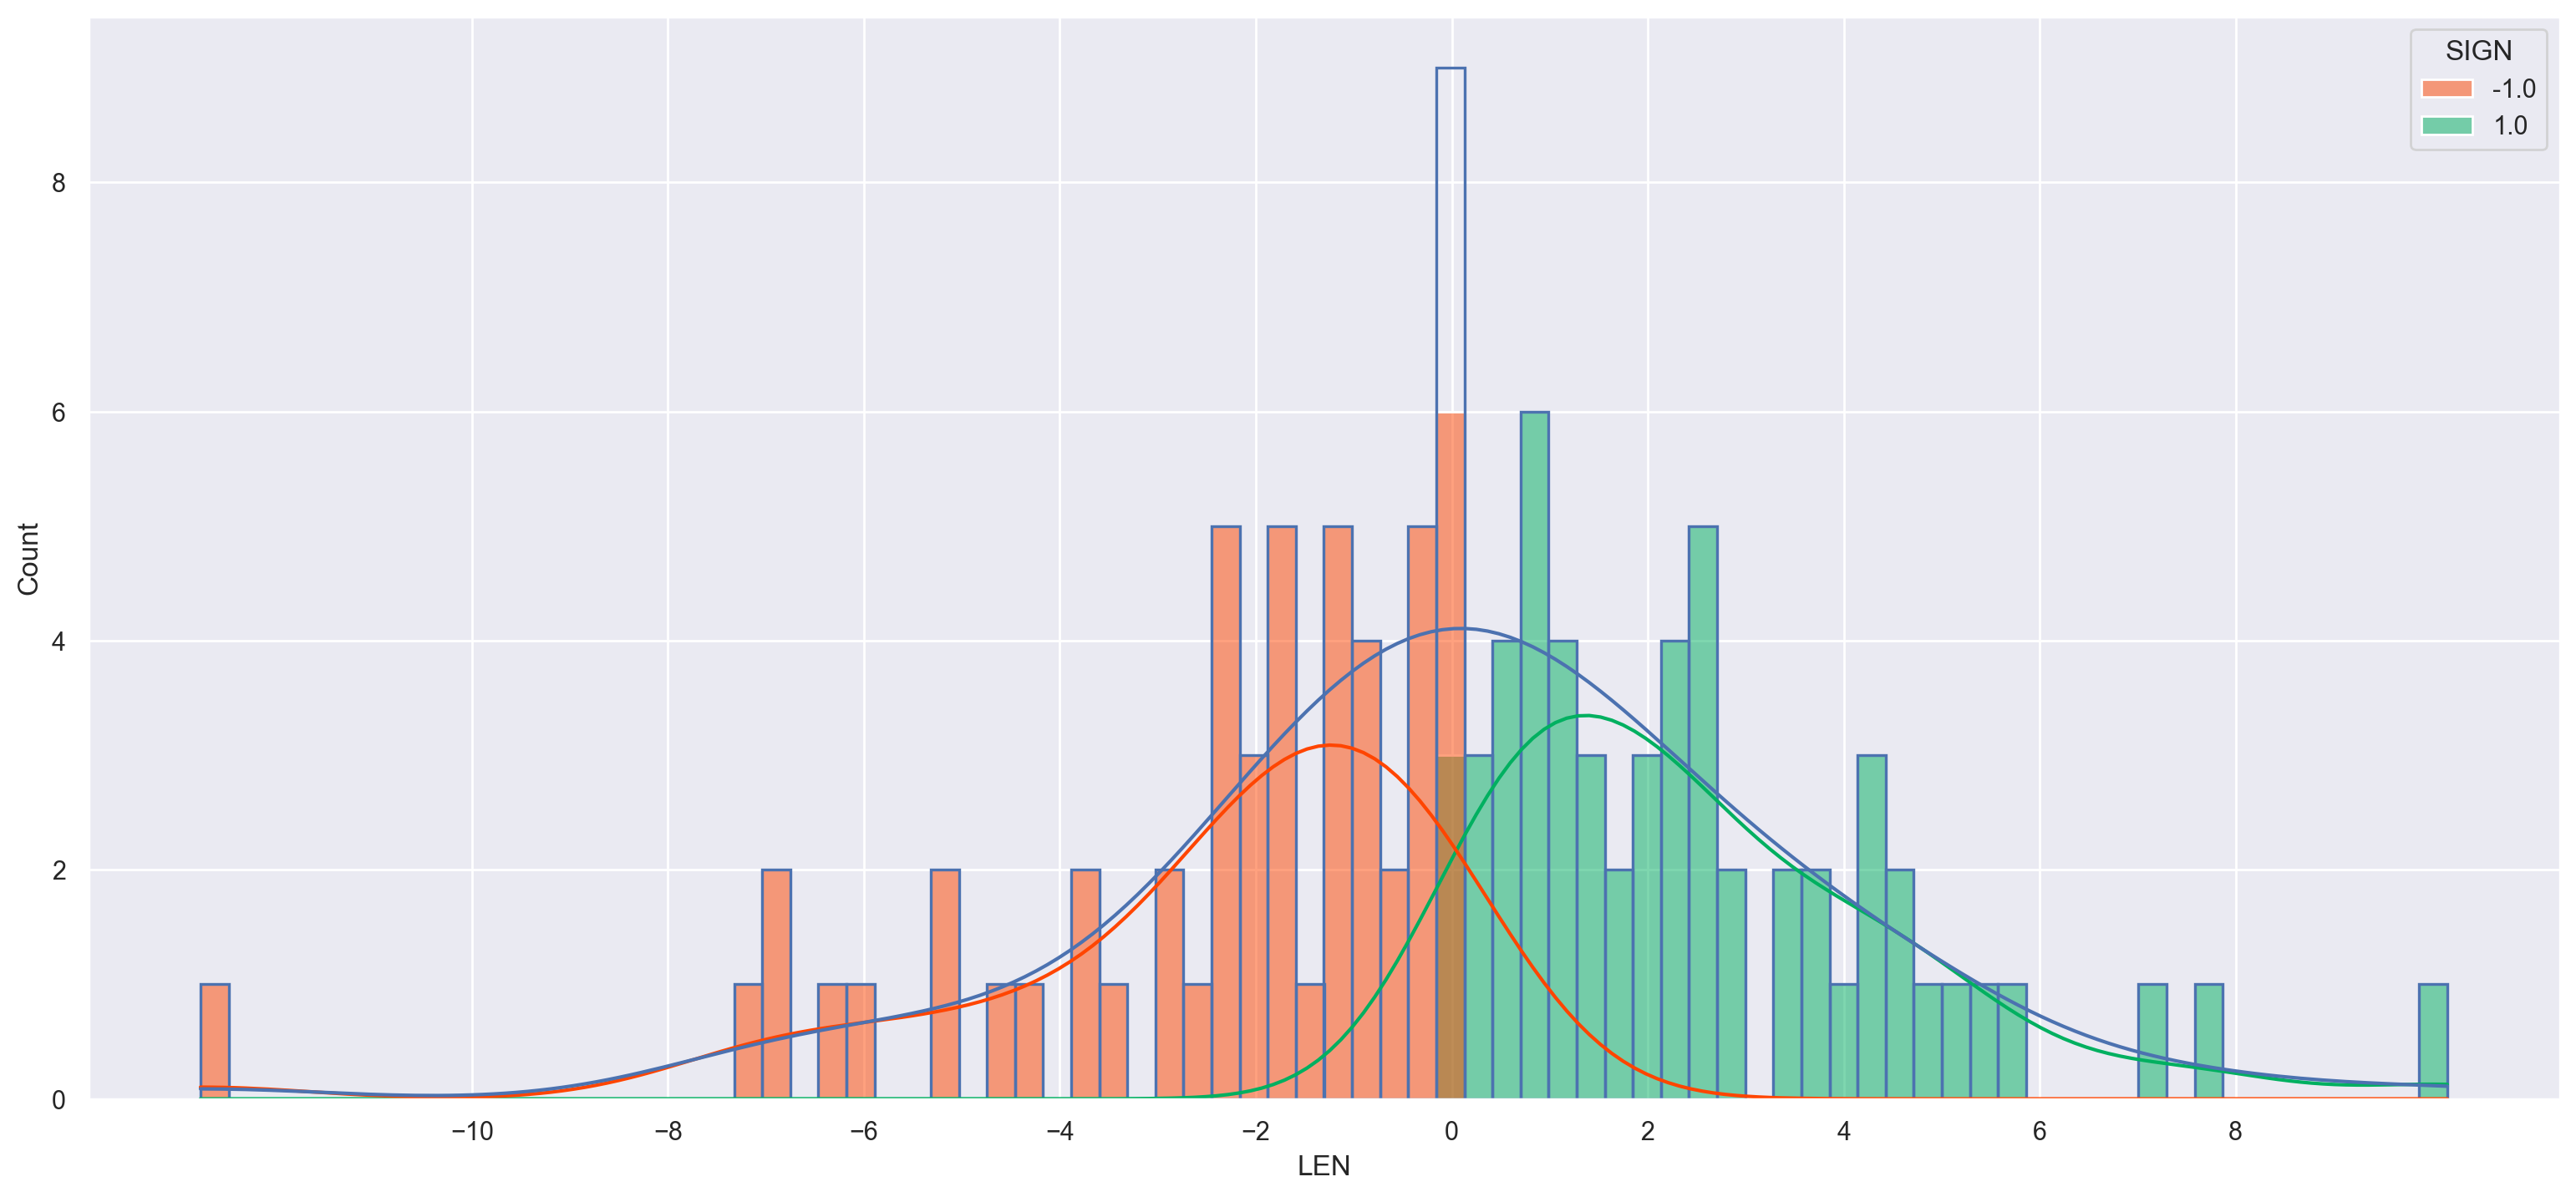

In [ ]:

plt.xticks(np.arange(-10, 10, step = 2));
my_palette1 = [red if (i > 0) else green for i in ohlc["SIGN"] ]
sns.histplot(data = ohlc, x = "LEN", kde = True, bins = 80, hue='SIGN', palette = my_palette1);
sns.histplot(data = ohlc, x = "LEN", kde = True, bins = 80, fill = 0);

In [ ]:
rise = ohlc[ohlc["LEN"] > 0][["LEN"]]
fall = abs(ohlc[ohlc["LEN"] < 0][["LEN"]])

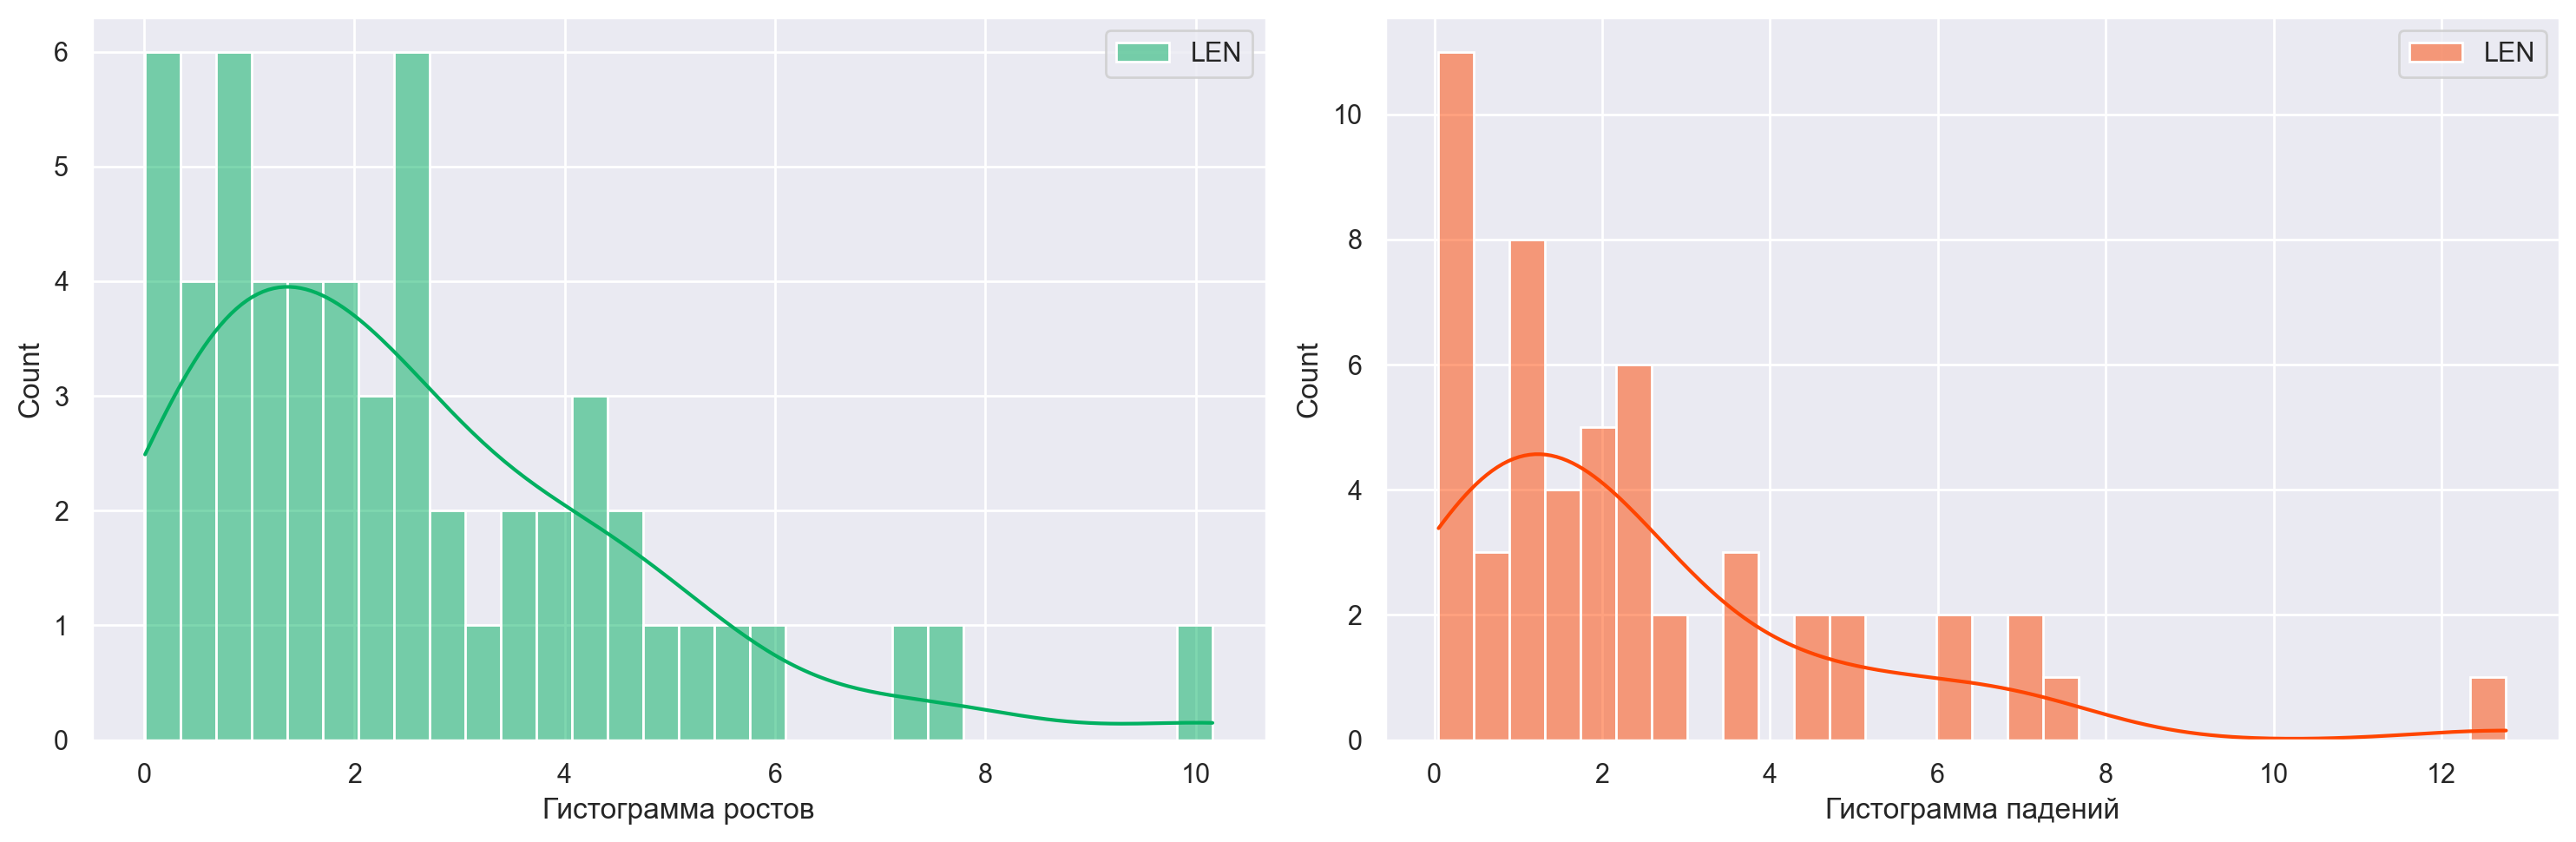

In [ ]:
green_palette = [green for i in rise ]
red_palette = [red for i in fall ]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=rise, kde=True, bins = 30,  ax=ax1, palette = green_palette);
ax1.set(xlabel="Гистограмма ростов")

sns.histplot(data=fall, kde=True, bins = 30, ax=ax2, palette = red_palette);
ax2.set(xlabel="Гистограмма падений")


fig.tight_layout();
plt.show();

## 3. Аппроксимация отрицательным биномиальным распределением

In [ ]:
from scipy.stats import nbinom
from scipy.stats import chisquare
def sample_nbinom_moments(observed):

    mean = observed.mean()
    var = observed.var()

    # param:
    p = mean / var  
    r = p * mean / (1 - p)
    expected = nbinom.rvs(r, p, size = len(observed))   

    fig, axes = plt.subplots(1, 1, figsize=(15, 10))
    axes.set(xlabel="Носитель")
    
    sns.histplot(data=observed, bins=30, ax=axes)
    sns.histplot(data=expected, ax=axes)
    
    fig.tight_layout()
    plt.show()
        
    return (r, p)

def chisquare_nbinom(observed, _r, _p):
    n = max(observed)
    f_obs = np.zeros(n)
    for i in range(n):
        f_obs[i] =  np.sum(observed == i)

    f_exp = np.zeros(n)
    for i in range(n):
        f_exp[i] = nbinom.pmf(i, _r, _p) * len(observed)

    f_exp[0] += sum(f_obs) - sum(f_exp)
    
    return chisquare(f_obs, f_exp)

## 4. Аппоксимация обобщенным $\gamma$-распределением

In [ ]:
from scipy.stats import gengamma
from scipy.stats import ks_2samp
def sample_gengamma(X):
    params = gengamma.fit(X)
    X_gengamma = gengamma.rvs(*params, size = len(X))
    
    fig, axes = plt.subplots(1, 1, figsize=(15, 10))
    
    sns.histplot(data=X, ax=axes)
    sns.histplot(data=X_gengamma, ax=axes)
    
    return params
def ks_2samp_gengamma(X, _params):
    X_gengamma = gengamma.rvs(*params, size = len(X))
    return ks_2samp(X, X_gengamma)

## 5. $\sum$ подряд идущих ростов и падений

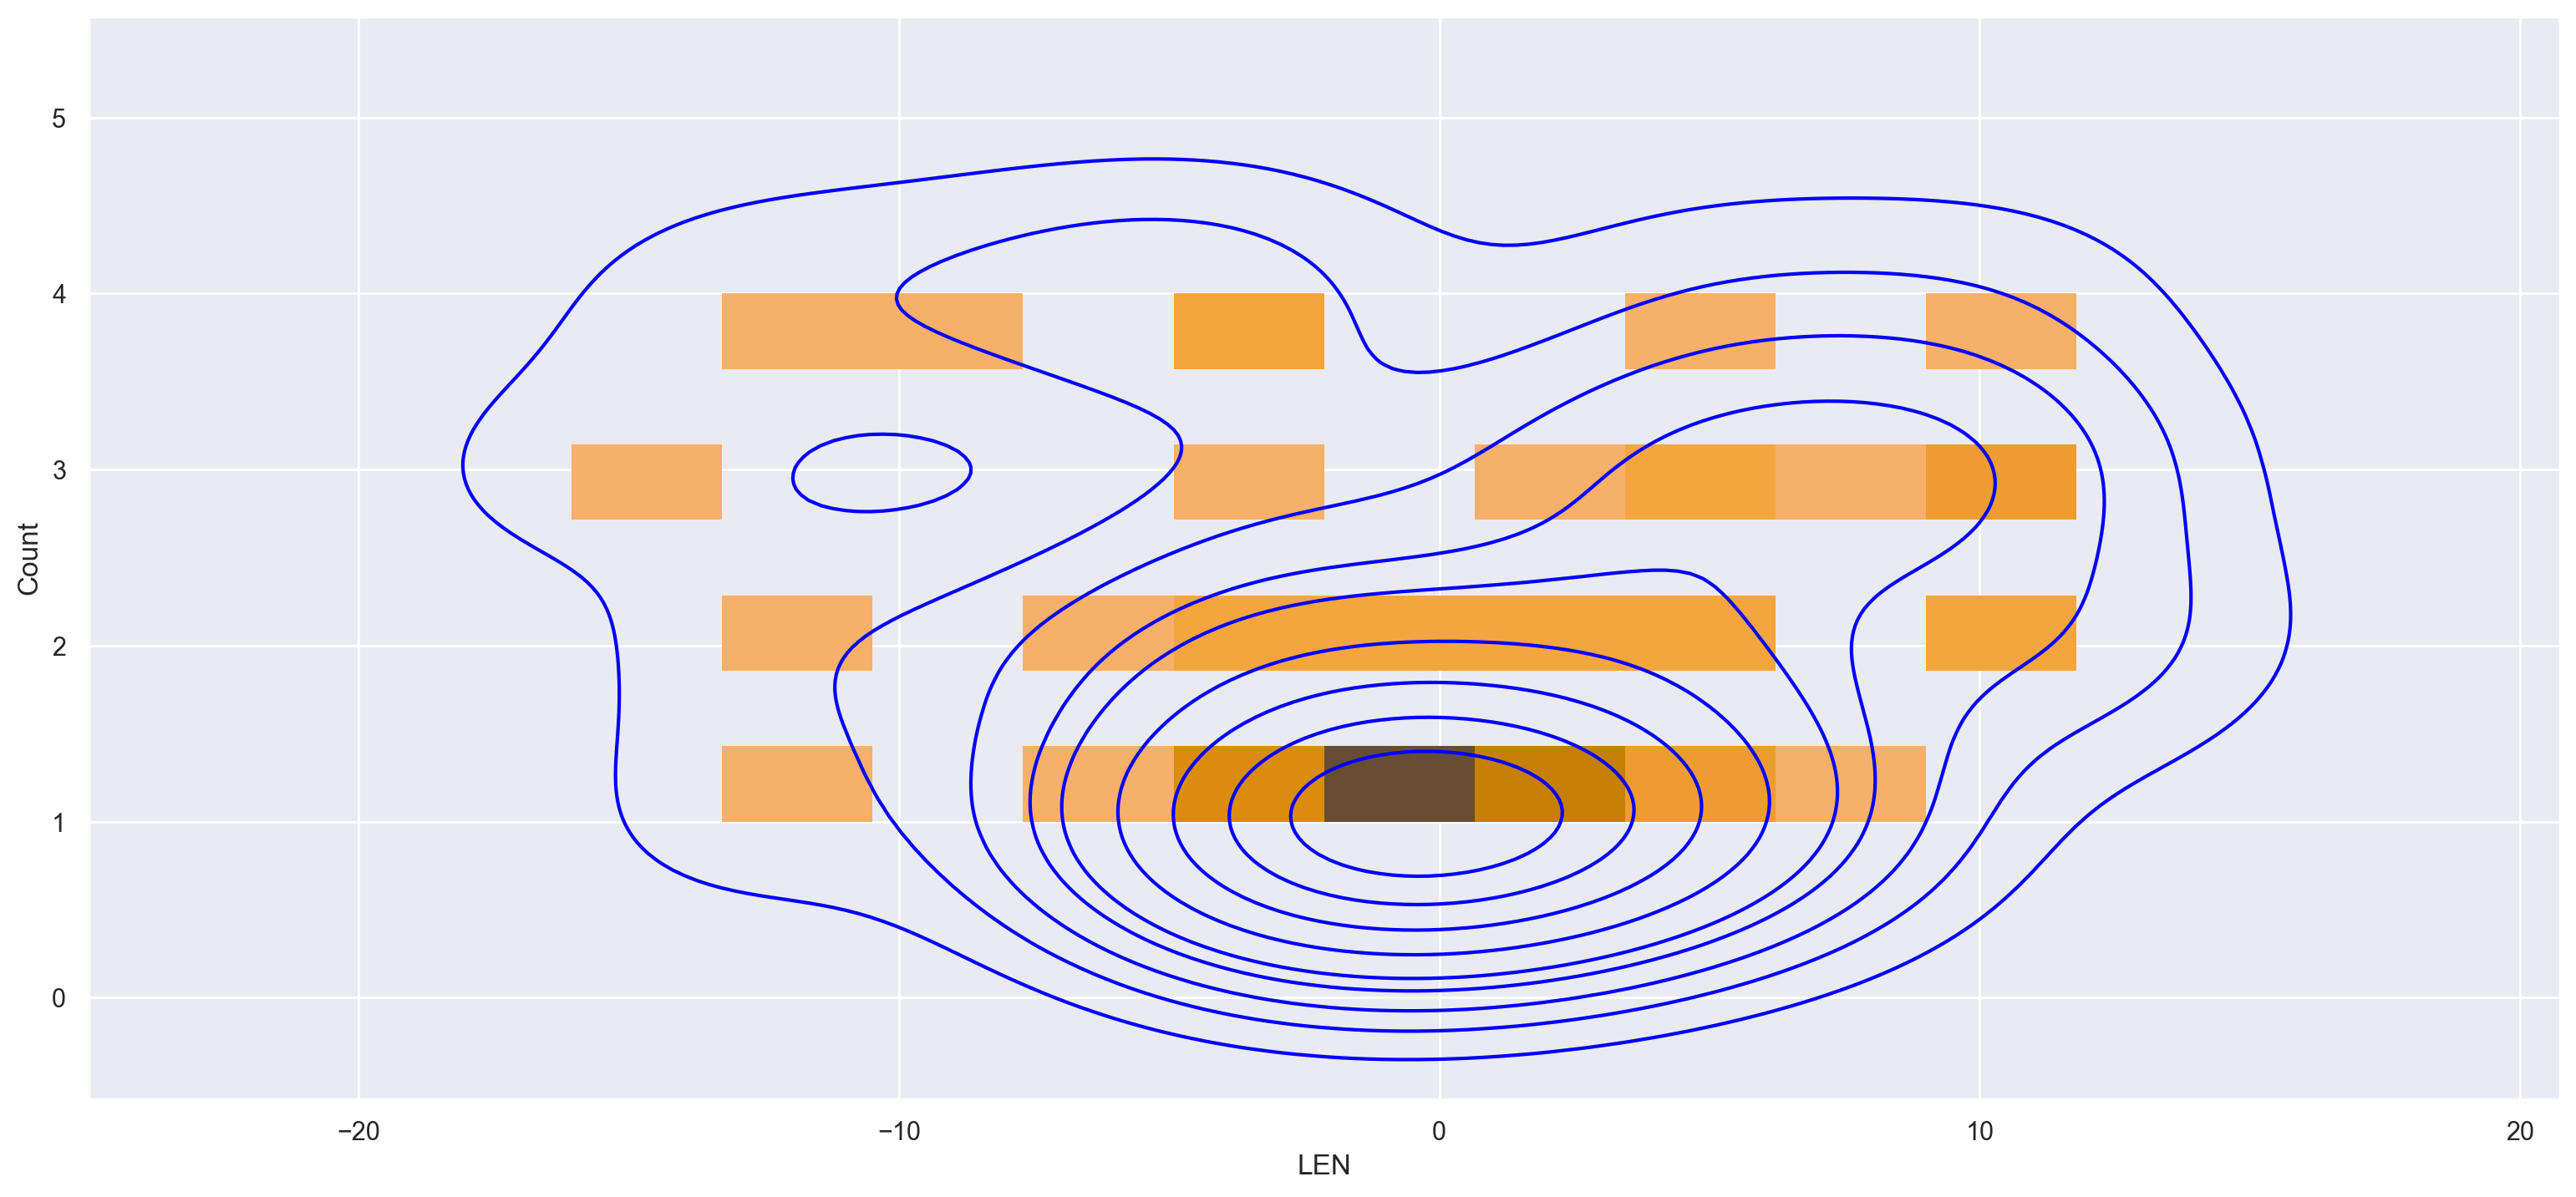

In [ ]:
cols = ["LEN", "Count"]
xlab = ["Суммарное изменение при ростах и падениях", 
        "Кол-во подряд идущих свечей одного цвета"]
fig, axes = plt.subplots()

sns.kdeplot(df2, x=cols[0], y=cols[1], ax=axes, color = 'blue');
sns.histplot(df2, x=cols[0], y=cols[1], ax=axes, color = 'orange');

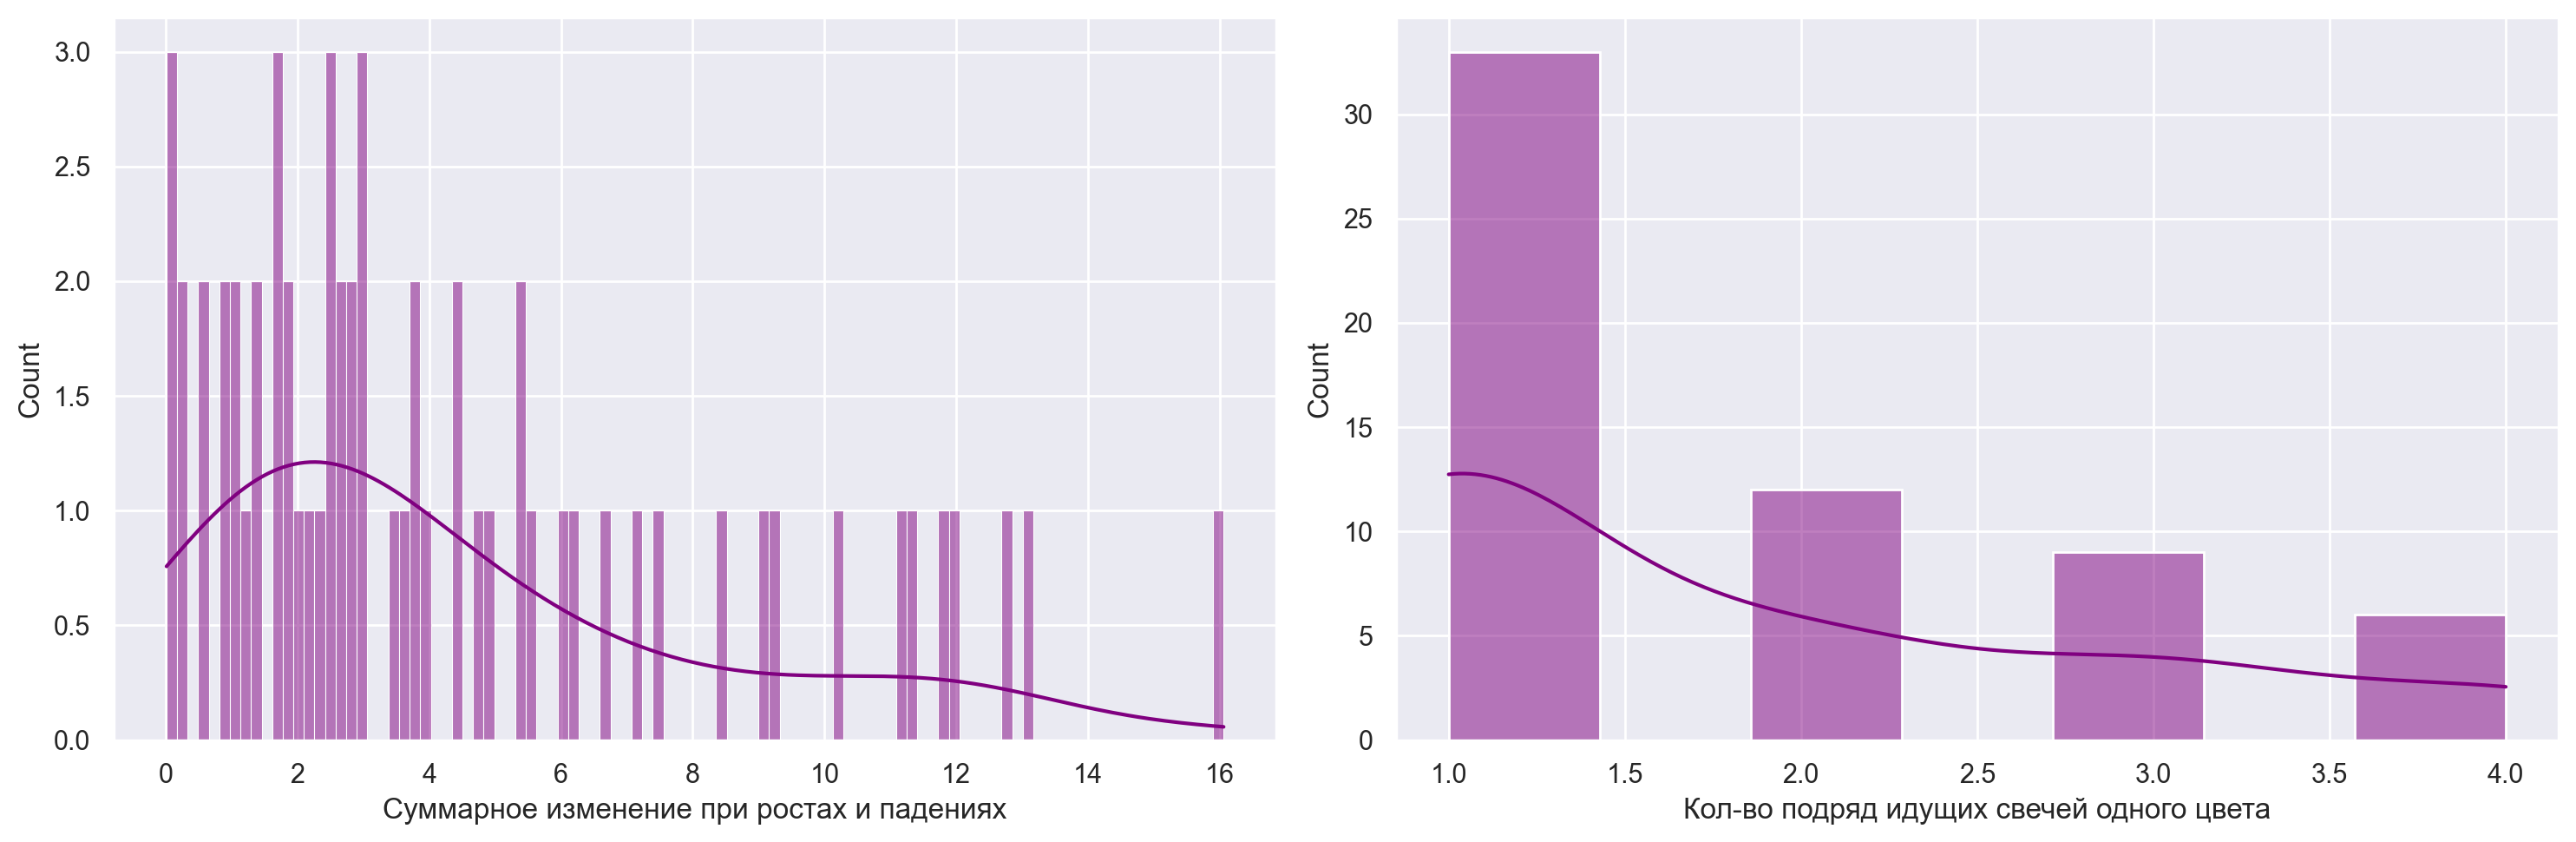

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df2[cols[0]].apply(abs), kde=True, bins=100, ax=ax1, color = 'purple');
ax1.set(xlabel=xlab[0])
sns.histplot(data=df2[cols[1]], kde=True, ax=ax2, color = 'purple');
ax2.set(xlabel=xlab[1])
fig.tight_layout()
plt.show();